# Reinforment Learning - Mario

The goal of this project is to train a reinforcement agent to play the classic Mario game.

The game environment is given by https://pypi.org/project/gym-super-mario-bros/

The code below shows an agent that is taking a random action at each time step.

In [2]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np

maxStorage = 10

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
frameBuffer = np.zeros((maxStorage, 240, 256, 3), dtype=np.uint8)

done = True
for step in range(10):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    frame = env.render(mode = 'rgb_array')
    if step < maxStorage:
        frameBuffer[step] = frame

# Understanding the Environment

The objective of this game is for the agent to move as far right as possible, as fast as possible without dying.

The reward function (r) of the environment is defined as the combination of position (v), game clock between frame (c) and death penalty (d)

r = v + c + d , where r is clipped between (-15,15)

v: This is the difference between the agent's x positions between frames (encourage the agent to move right)  
v = x1 - x0  
moving right: v > 0  
moving left : v < 0  
not moving  : v = 0  

c: This is the difference between the game clock between frames (encourage the agent to no stand still)  
c = c0 - c1,   
where, c0 is the clock reading before the step and c1 is the clock reading after the step.

d: This is the penalty that penalizes the agent from dying (encourage the agent to stay alive in the game)  
alive: d = 0  
dead : d = -15  

In [3]:
print("Available Action: ", env.get_action_meanings())

Available Action:  ['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']


Game Screen Size: (240, 256, 3)


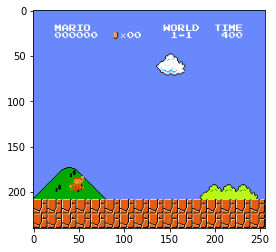

In [18]:
import random
import matplotlib.pyplot as plt

randomImg = random.randrange(0,maxStorage-1,1)
print("Game Screen Size:", frameBuffer[randomImg].shape)
plt.imshow(frameBuffer[randomImg])

# Preprocessing Game Screen for training

The Game Screen is an image with the shape of (240, 256, 3). In order to increase the speed of training, several steps were taken to reduce the size of the image. First, the image will be converted into a grayscale image. Next, the image will be cropped vertically, as we don't need the information on the score and time on the game screen (These information will be provide through the reward function). Therefore, all images will go through the preprocessImage function below.

In [5]:
import cv2
def preprocessImage(image):
    output = cv2.cvtColor(frameBuffer[2], cv2.COLOR_RGB2GRAY)
    output = output[100:, :]
    return output

New Image Size:  (140, 256)


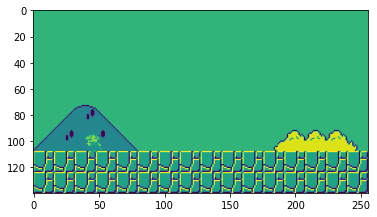

In [6]:
processedImage = preprocessImage(frameBuffer[randomImg])
plt.imshow(processedImage)
print("New Image Size: ", processedImage.shape)

# Experience Replay

When the agent is interacting with the environment, the sequence of experience will be highly correlated. In other word, it is extremely likely that the agent will learn action value pair will diverage or oscillate based on that correlation. A technique of experience replay will be used here to break that correlation.

Experience Replay make use of a replay buffer, which is a collections of all the experience tuples (S, A, R, S'). During training, a small batch of experience tuples will be sampled randomly from the replay buffer and this will allow us to break up any correlation araise from a sequence of experience.


In [7]:
import torch
import numpy as np
from collections import deque, namedtuple
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# DQN Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
   
    def __init__(self, channels, action_size, seed):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channels, 4, 3), 
                                   nn.Conv2d(4, 4, 3))
        self.layer2 = nn.Sequential(nn.Conv2d(4, 4, 3), 
                                   nn.Conv2d(4, 4, 3))
        self.pool = nn.MaxPool2d(2)
        flatten_len = 4 * 32 * 61
        self.fc1 = nn.Linear(flatten_len, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)


        
        
    def forward(self, x):
        x = self.pool(F.relu(self.layer1(x)))
        x = self.pool(F.relu(self.layer2(x)))
        x = x.view(-1, 4 * 32 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Agent

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

import torch
import torch.nn.functional as F
import torch.optim as optim

class Agent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, seed):
        """"Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size[0], action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size[0], action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps=0.):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
        
            
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

# Watch Agent

In [12]:
episode = 10
NUM_FRAME = 4
FRAME_SIZE = (140, 256)
tmax = 500
seed = 1
nn_frames = deque(maxlen = NUM_FRAME)

state_size = (NUM_FRAME,) + (FRAME_SIZE)
action_size = len( env.get_action_meanings())
seef = 1

agent = Agent(state_size, action_size, seed)

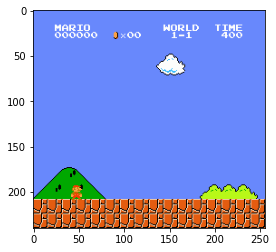

In [13]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

rewards = 0

for i in range(NUM_FRAME):
    nn_frames.append(np.zeros(FRAME_SIZE))
nn_frames.append(np.copy(preprocessImage(state)))
next_states = np.array(nn_frames)
        
        
for j in range(200):
    action = agent.act(next_states)
    state, reward, done, _ = env.step(action)
    rewards += reward
    nn_frames.append(np.copy(preprocessImage(state)))
    next_states = np.array(nn_frames)
    if done:
        break 
        

# Train Agent

In [14]:
episode = 100
discount_rate = 0.99
NUM_FRAME = 4
FRAME_SIZE = (140, 256)
t_max = 500
nn_frames = deque(maxlen = NUM_FRAME)
action_size = len( env.get_action_meanings())
state_size = (NUM_FRAME,) + (FRAME_SIZE)
sum_rewards = []

In [16]:
done = True
agent = Agent(state_size, action_size, seed)

for e in range(episode):
    if done:
        state = env.reset()
        sum_reward = 0
        # we want to keep 4 consecutive frames as 1 state to keep some data on 
        for i in range(NUM_FRAME):
            nn_frames.append(np.zeros(FRAME_SIZE))
        nn_frames.append(np.copy(preprocessImage(state)))
        states = np.array(nn_frames)
        
        for t in range(t_max):
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            nn_frames.append(np.copy(preprocessImage(state)))
            next_states = np.array(nn_frames)
            agent.step(states, action, reward, next_states, done)
            sum_reward += reward
            states = next_states
    
            if done or reward < -10:
                break
        
    print(e)
    
    #print('\rEpisode {}\tCurrent Score: {:.2f}'.format(e, sum_rewards[-1]), end="")
    ## display some progress every 20 iterations
    #if (e+1) % (episode // 20) ==0:
    #    print(" | Episode: {0:d}, average score: {1:f}".format(e+1,np.mean(sum_rewards[-20:])))
        
    
env.close

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<bound method Wrapper.close of <JoypadSpace<TimeLimit<SuperMarioBrosEnv<SuperMarioBros-v0>>>>>

In [17]:
sum_rewards

[657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657,
 657]